In [ ]:
# Import tsv file
import pandas as pd
import os

# Read the TSV file
df = pd.read_csv('hepatitis.tsv', sep='\t')

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print(df.head())

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')

In [ ]:
# Find outliers
def find_outliers(df):
    # Calculate the Z-score for each column
    z_scores = (df - df.mean()) / df.std()
    # Identify outliers (Z-score > 3 or < -3)
    outliers = (z_scores > 3) | (z_scores < -3)
    return outliers
    
# Find outliers in the dataset
outliers = find_outliers(df)
# Print outliers
print("Outliers in the dataset:")
for col in outliers.columns:
    if outliers[col].any():
        print(f"Column '{col}':")
        print(df[outliers[col]])
        print()

# Drop outliers
print(df.shape)
df = df[~outliers.any(axis=1)]
print(df.shape)

# Find IQR outliers in "age"
IQR = df['age'].quantile(0.75) - df['age'].quantile(0.25)
lower_bound = df['age'].quantile(0.25) - 1.5 * IQR
upper_bound = df['age'].quantile(0.75) + 1.5 * IQR
outliers_iqr = (df['age'] < lower_bound) | (df['age'] > upper_bound)
# Print IQR outliers
print("IQR outliers in 'age':")
print(df[outliers_iqr])

In [ ]:
# See if there are any missing values
# print(df.isnull().sum())

# See if there are any duplicates
# print(df.duplicated().sum())

# Print summary statistics
# print(df.describe())

# Print min and max of each column
print(df.min())
print(df.max())

# Convert age into a categorical variable by dividing into 3 groups (bins)
x = 1/3
def age_category(age):
  R1 = df['age'].quantile(x)
  R2 = df['age'].quantile(2*x)
  print(R1, R2)
  if age <= R1:
    return 0
  elif age <= R2:
    return 1
  else:
    return 2
    
print(df.columns)
    
# df['age'] = df['age'].apply(age_category)

In [ ]:
# Normalize the data column-wise
def normalize(df):
    df = (df - df.min()) / (df.max() - df.min())
    return df

# Normalize the data
df = normalize(df)

# Print the first 5 rows of the normalized data
print(df.head())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import io

print("1. Basic Dataset Information")
print("-" * 30)
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\n2. Column Names and Data Types")
print("-" * 30)
print(df.dtypes)

print("\n3. Summary Statistics")
print("-" * 30)
print(df.describe())

print("\n4. Missing Values")
print("-" * 30)
print(df.isnull().sum())

# Checking for unique values in each column
print("\n5. Unique Values per Column")
print("-" * 30)
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")

# Understanding categorical variables
print("\n6. Categorical Variables Distribution")
print("-" * 30)
categorical_cols = ['SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 
                    'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE', 'SPIDERS', 'ASCITES', 
                    'VARICES', 'HISTOLOGY', 'target']
# to lower case
categorical_cols = [col.lower() for col in categorical_cols]

for col in categorical_cols:
    print(f"\n{col} Value Counts:")
    print(df[col].value_counts())

# Set up plotting
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')

# Target variable distribution
plt.subplot(2, 2, 2)
sns.countplot(x='target', data=df)
plt.title('Target Distribution')

# Sex distribution
plt.subplot(2, 2, 3)
sns.countplot(x='sex', data=df)
plt.title('Sex Distribution (1=Male, 2=Female)')

# Feature correlation with target
plt.subplot(2, 2, 4)
corr_with_target = df.corr()['target'].sort_values(ascending=False)
# remove target from the correlation
corr_with_target = corr_with_target.drop('target')
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.title('Feature Correlation with Target')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('basic_plots.png')

# Create correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# Analyze numerical features by target
numerical_cols = ['AGE', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']
# Convert to lower case
numerical_cols = [col.lower() for col in numerical_cols]
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col} by Target')

plt.tight_layout()
plt.savefig('numerical_by_target.png')

# Categorical features by target
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols[:-1]):  # Exclude target from this plot
    plt.subplot(4, 4, i+1)
    crosstab = pd.crosstab(df[col], df['target'], normalize='index')
    crosstab.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Target')
    plt.ylabel('Proportion')
    plt.legend(title='Target')

plt.tight_layout()
plt.savefig('categorical_by_target.png')

# Checking for age patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='age', data=df)
plt.title('Age Distribution by Target')
plt.savefig('age_by_target.png')

# Pairplot for key numerical variables
plt.figure(figsize=(12, 10))
sns.pairplot(df[numerical_cols + ['target']], hue='target')
plt.suptitle('Pairplot of Numerical Features by Target', y=1.02)
plt.savefig('pairplot.png')

print("\n7. Key Observations")
print("-" * 30)

# Target distribution
target_counts = df['target'].value_counts()
print(f"Target distribution: {target_counts.to_dict()}")

# Age statistics by target
age_by_target = df.groupby('target')['age'].agg(['mean', 'median', 'min', 'max'])
print("\nAge statistics by target:")
print(age_by_target)

# Key lab values by target
lab_cols = ['BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']
# Convert to lower case
lab_cols = [col.lower() for col in lab_cols]
lab_by_target = df.groupby('target')[lab_cols].agg(['mean', 'median'])
print("\nLab values by target:")
print(lab_by_target)

# Feature importance based on correlation with target
important_features = corr_with_target.abs().sort_values(ascending=False)
print("\nFeatures sorted by correlation strength with target:")
print(important_features)

In [ ]:
# save the cleaned dataset as CSV
# df.to_csv('hepatitis_cleaned.csv', index=False)
# 
# save the cleaned dataset as TSV
df.to_csv('hepatitis_cleaned.tsv', sep='\t', index=False)

In [ ]:
# print the ratio of the target variable
print("\nTarget variable ratio:")
print(df['target'].value_counts(normalize=True))

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('hepatitis_cleaned.tsv', sep='\t')

# Print the columns that are binary
binary_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nBinary columns:")
for col in binary_cols:
    if df[col].nunique() == 2:
        print(f"{col}: {df[col].unique()}")

In [3]:
# Oversampling

import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('hepatitis_cleaned.tsv', sep='\t')

# Separate the target variable
X = df.drop(columns=['target'])
y = df['target']
# Check the class distribution
print("\nClass distribution before oversampling:")
print(y.value_counts(normalize=True))

# Separate the majority and minority classes
majority_class = df[df['target'] == 1]
minority_class = df[df['target'] == 0]
# Oversample the minority class
from sklearn.utils import resample
# Upsample the minority class
minority_upsampled = resample(minority_class, 
                               replace=True,     # sample with replacement
                               n_samples=len(majority_class),    # to match majority class
                               random_state=42) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([majority_class, minority_upsampled])
# Check the new class distribution
print("\nClass distribution after oversampling:")
print(df_upsampled['target'].value_counts(normalize=True))
# Save the upsampled dataset
df_upsampled.to_csv('hepatitis_upsampled.tsv', sep='\t', index=False)


Class distribution before oversampling:
target
1.0    0.792208
0.0    0.207792
Name: proportion, dtype: float64

Class distribution after oversampling:
target
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


1. Basic Dataset Information
------------------------------
Shape: (244, 20)

First 5 rows:
        age  sex  steroid  antivirals  fatigue  malaise  anorexia  liver_big  \
0  0.408451  0.0      0.5         1.0      1.0      1.0       1.0        0.5   
1  0.535211  0.0      0.5         0.0      1.0      1.0       1.0        0.5   
2  0.563380  0.0      0.0         0.0      1.0      1.0       1.0        0.5   
3  0.408451  0.0      0.0         1.0      1.0      1.0       1.0        0.5   
4  0.605634  0.0      0.5         1.0      1.0      1.0       1.0        0.5   

   liver_firm  spleen_palpable  spiders  ascites  varices  bilirubin  \
0         0.5              0.5      0.5      0.5      0.5   0.088235   
1         0.5              0.5      0.5      0.5      0.5   0.294118   
2         0.5              0.5      0.5      0.5      0.5   1.000000   
3         0.5              0.0      0.5      0.5      0.5   0.147059   
4         0.5              0.5      0.5      0.5      0.5   0.20588

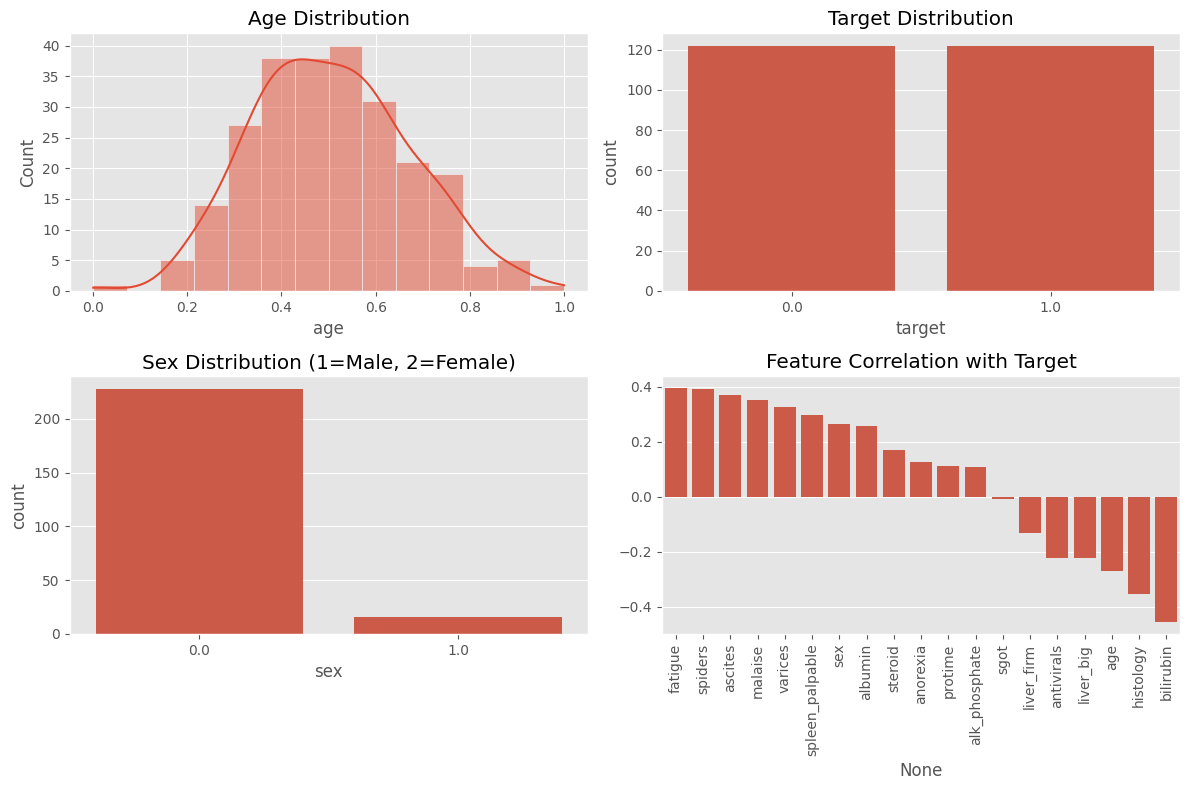

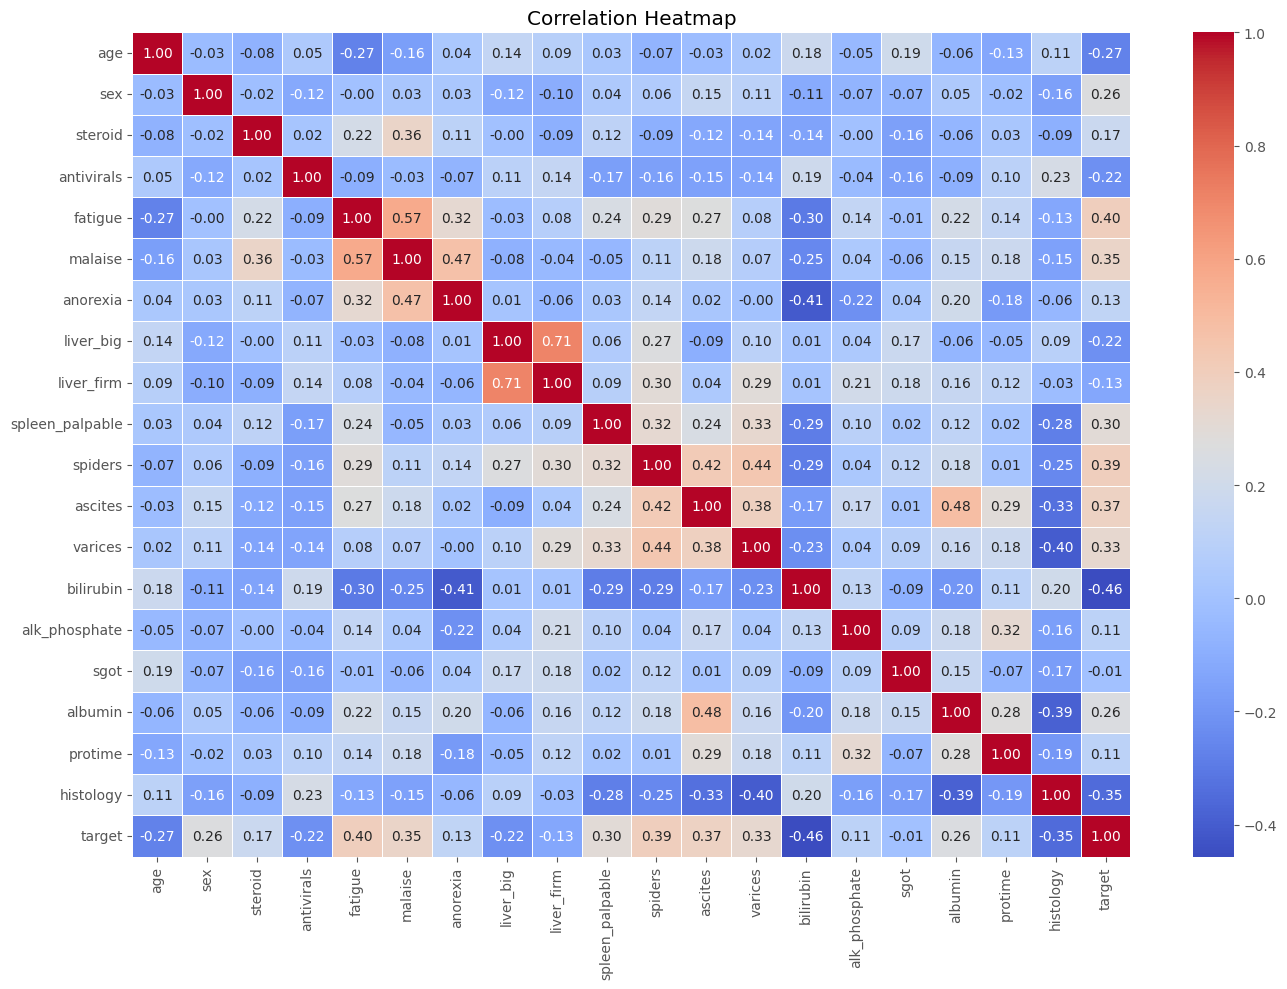

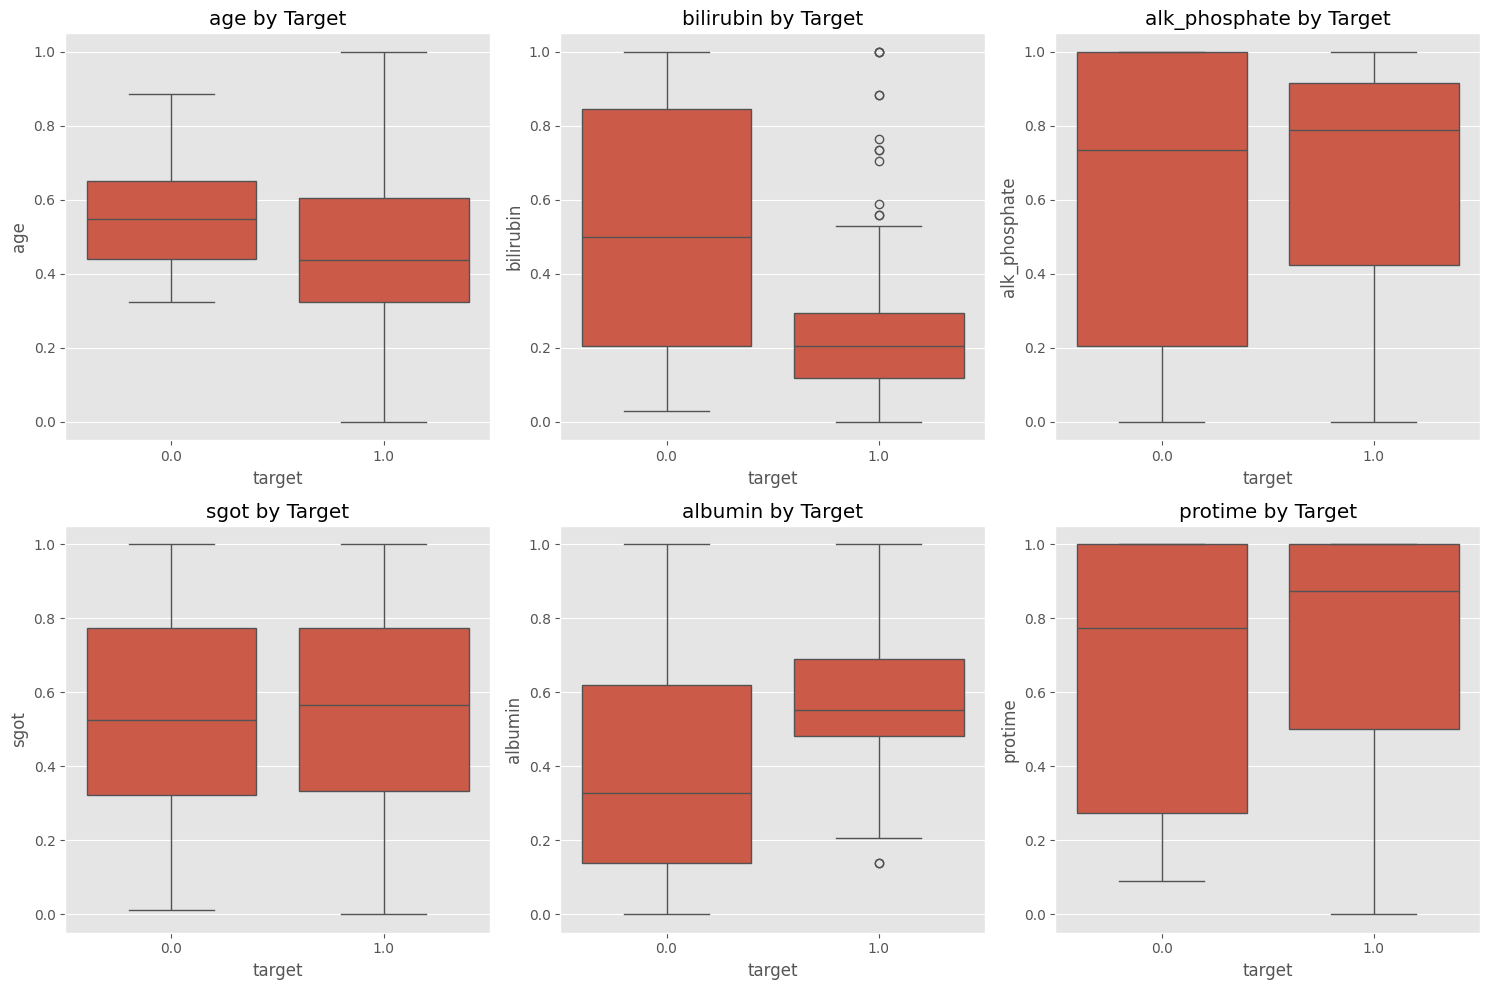

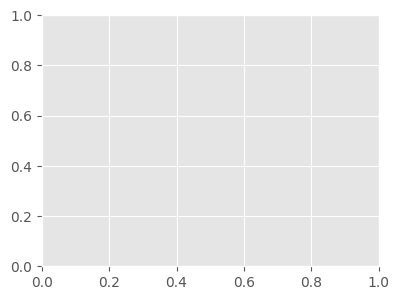

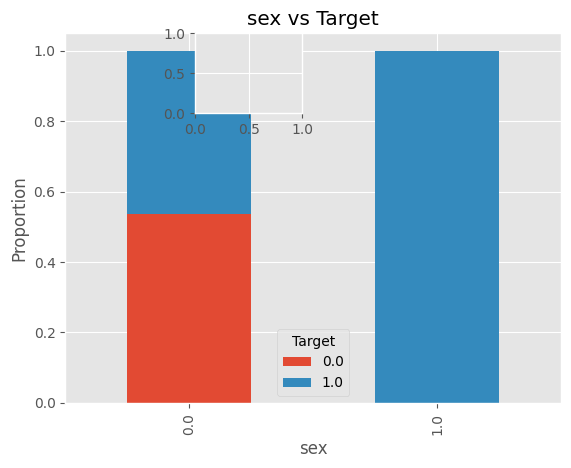

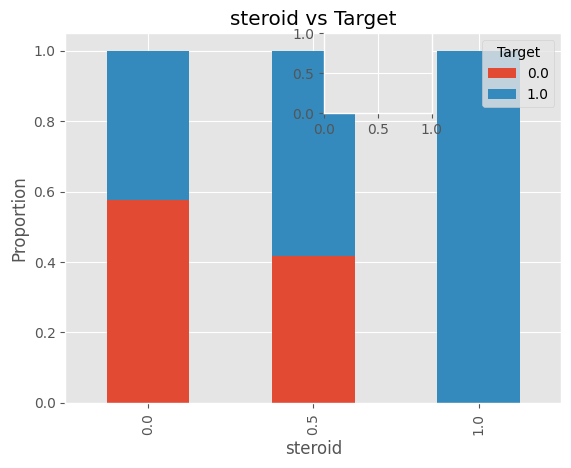

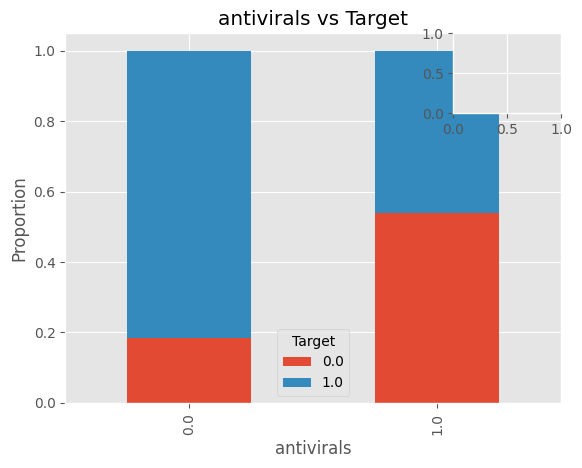

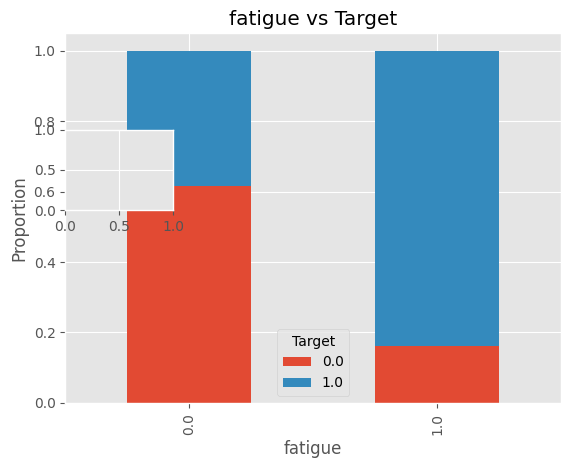

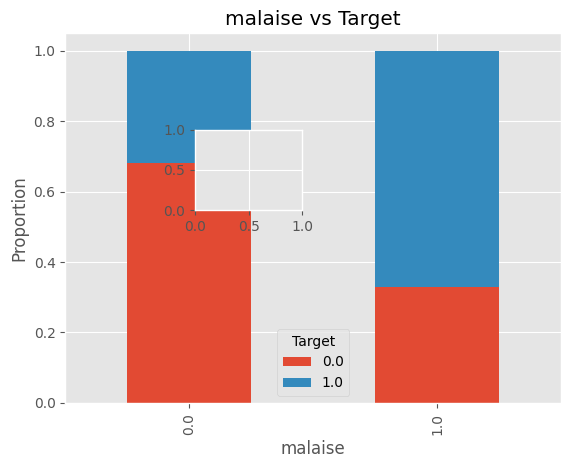

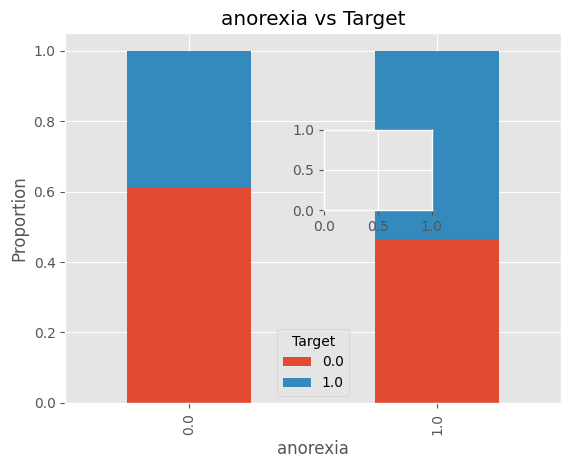

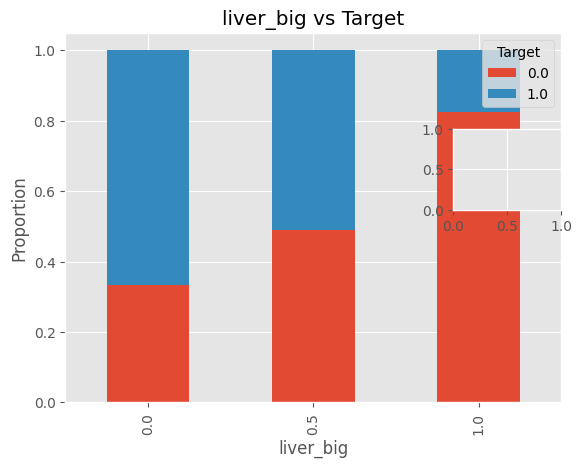

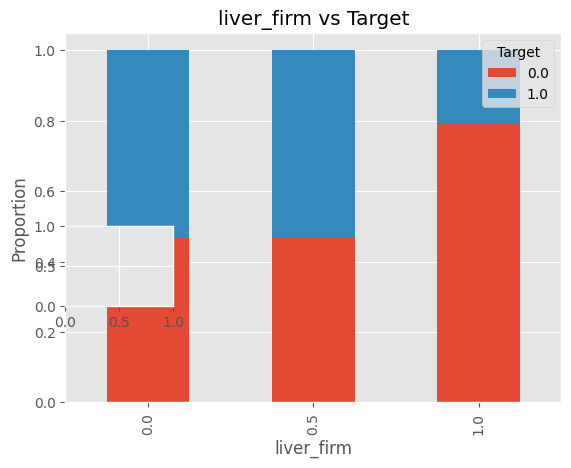

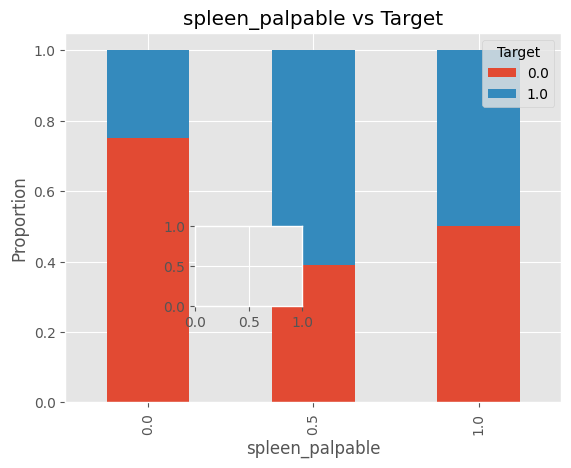

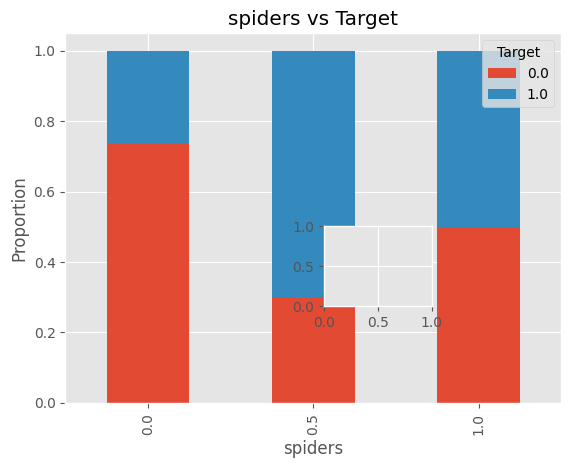

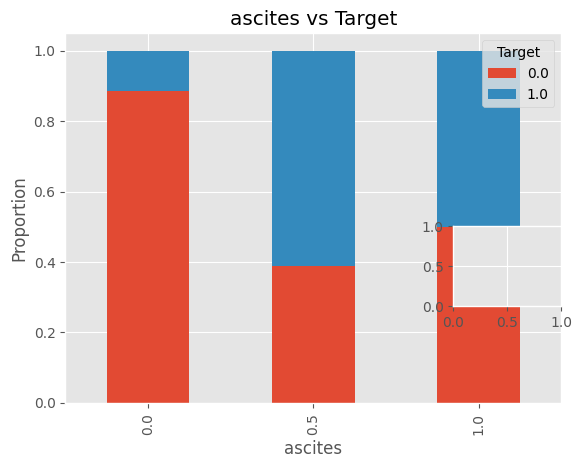

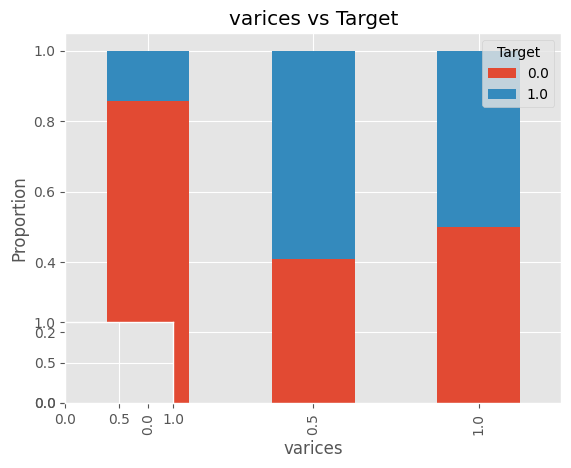

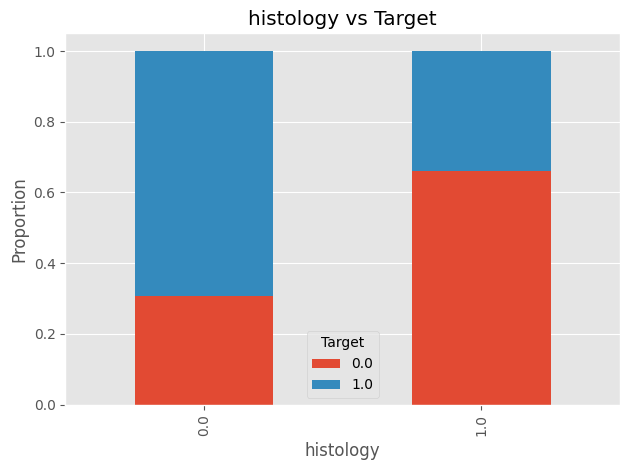

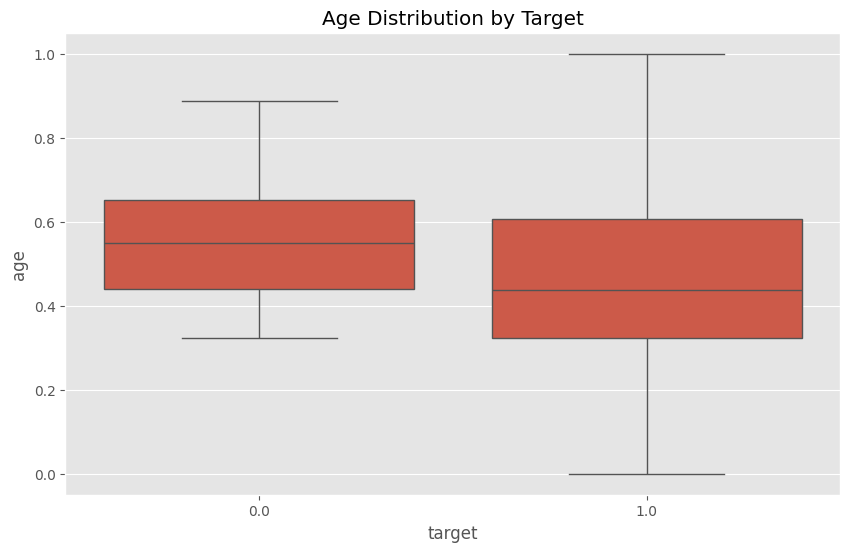

<Figure size 1200x1000 with 0 Axes>

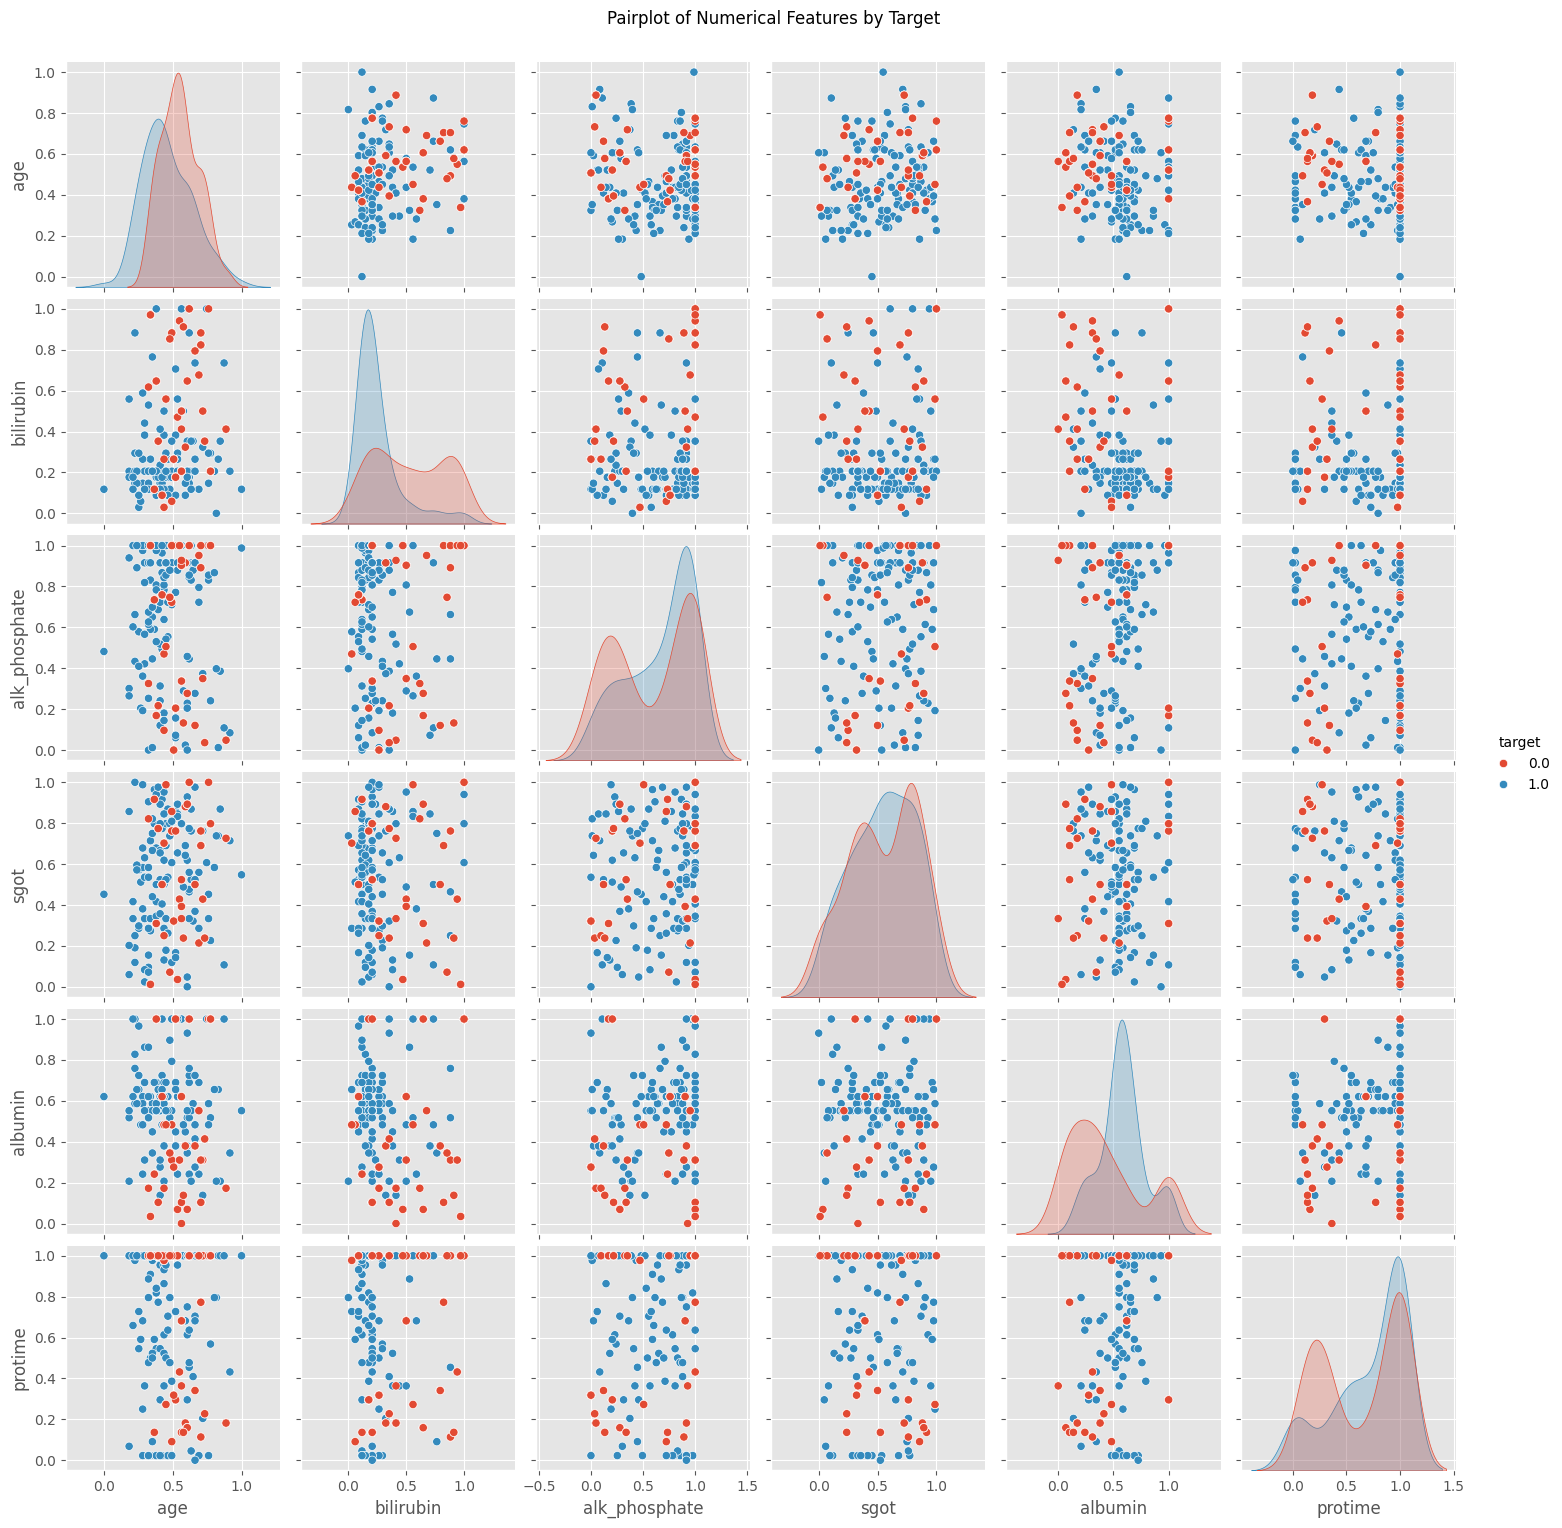

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import io

# Load the dataset
df = pd.read_csv('hepatitis_upsampled.tsv', sep='\t')

print("1. Basic Dataset Information")
print("-" * 30)
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\n2. Column Names and Data Types")
print("-" * 30)
print(df.dtypes)

print("\n3. Summary Statistics")
print("-" * 30)
print(df.describe())

print("\n4. Missing Values")
print("-" * 30)
print(df.isnull().sum())

# Checking for unique values in each column
print("\n5. Unique Values per Column")
print("-" * 30)
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")

# Understanding categorical variables
print("\n6. Categorical Variables Distribution")
print("-" * 30)
categorical_cols = ['SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 
                    'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE', 'SPIDERS', 'ASCITES', 
                    'VARICES', 'HISTOLOGY', 'target']
# to lower case
categorical_cols = [col.lower() for col in categorical_cols]

for col in categorical_cols:
    print(f"\n{col} Value Counts:")
    print(df[col].value_counts())

# Set up plotting
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')

# Target variable distribution
plt.subplot(2, 2, 2)
sns.countplot(x='target', data=df)
plt.title('Target Distribution')

# Sex distribution
plt.subplot(2, 2, 3)
sns.countplot(x='sex', data=df)
plt.title('Sex Distribution (1=Male, 2=Female)')

# Feature correlation with target
plt.subplot(2, 2, 4)
corr_with_target = df.corr()['target'].sort_values(ascending=False)
# remove target from the correlation
corr_with_target = corr_with_target.drop('target')
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.title('Feature Correlation with Target')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('basic_plots.png')

# Create correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# Analyze numerical features by target
numerical_cols = ['AGE', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']
# Convert to lower case
numerical_cols = [col.lower() for col in numerical_cols]
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col} by Target')

plt.tight_layout()
plt.savefig('numerical_by_target.png')

# Categorical features by target
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols[:-1]):  # Exclude target from this plot
    plt.subplot(4, 4, i+1)
    crosstab = pd.crosstab(df[col], df['target'], normalize='index')
    crosstab.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Target')
    plt.ylabel('Proportion')
    plt.legend(title='Target')

plt.tight_layout()
plt.savefig('categorical_by_target.png')

# Checking for age patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='age', data=df)
plt.title('Age Distribution by Target')
plt.savefig('age_by_target.png')

# Pairplot for key numerical variables
plt.figure(figsize=(12, 10))
sns.pairplot(df[numerical_cols + ['target']], hue='target')
plt.suptitle('Pairplot of Numerical Features by Target', y=1.02)
plt.savefig('pairplot.png')

print("\n7. Key Observations")
print("-" * 30)

# Target distribution
target_counts = df['target'].value_counts()
print(f"Target distribution: {target_counts.to_dict()}")

# Age statistics by target
age_by_target = df.groupby('target')['age'].agg(['mean', 'median', 'min', 'max'])
print("\nAge statistics by target:")
print(age_by_target)

# Key lab values by target
lab_cols = ['BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']
# Convert to lower case
lab_cols = [col.lower() for col in lab_cols]
lab_by_target = df.groupby('target')[lab_cols].agg(['mean', 'median'])
print("\nLab values by target:")
print(lab_by_target)

# Feature importance based on correlation with target
important_features = corr_with_target.abs().sort_values(ascending=False)
print("\nFeatures sorted by correlation strength with target:")
print(important_features)